# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 


##### The process starts with the Business Understanding. In that step, we define which problem, objectives and requirements of the project.
##### Without a specific problem statement, We’ll make an assumption based on the file name. Let’s say our objective is to predict the price of used cars based on various features

#### Objective: Predict the price of used cars, and what factors make a car more or less expensive

#### Objective: Predict the price of used cars, and what factors make a car more or less expensive.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

##### The second step deals with the data which should be used to support the solution of the business problem. Adding to the foundation of Business Understanding, it drives the focus to identify, collect, and analyze the data sets that can help you accomplish the project goals. 

In [62]:
import copy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from plotly.figure_factory import create_table
from datetime import datetime

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, HuberRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings

from statsmodels.sandbox.stats.stats_mstats_short import edf_normal_inverse_transformed

warnings.filterwarnings("ignore")

In [63]:
# Loading data
df = pd.read_csv('data/vehicles.csv')

In [64]:
# data size
df.shape

(426880, 18)

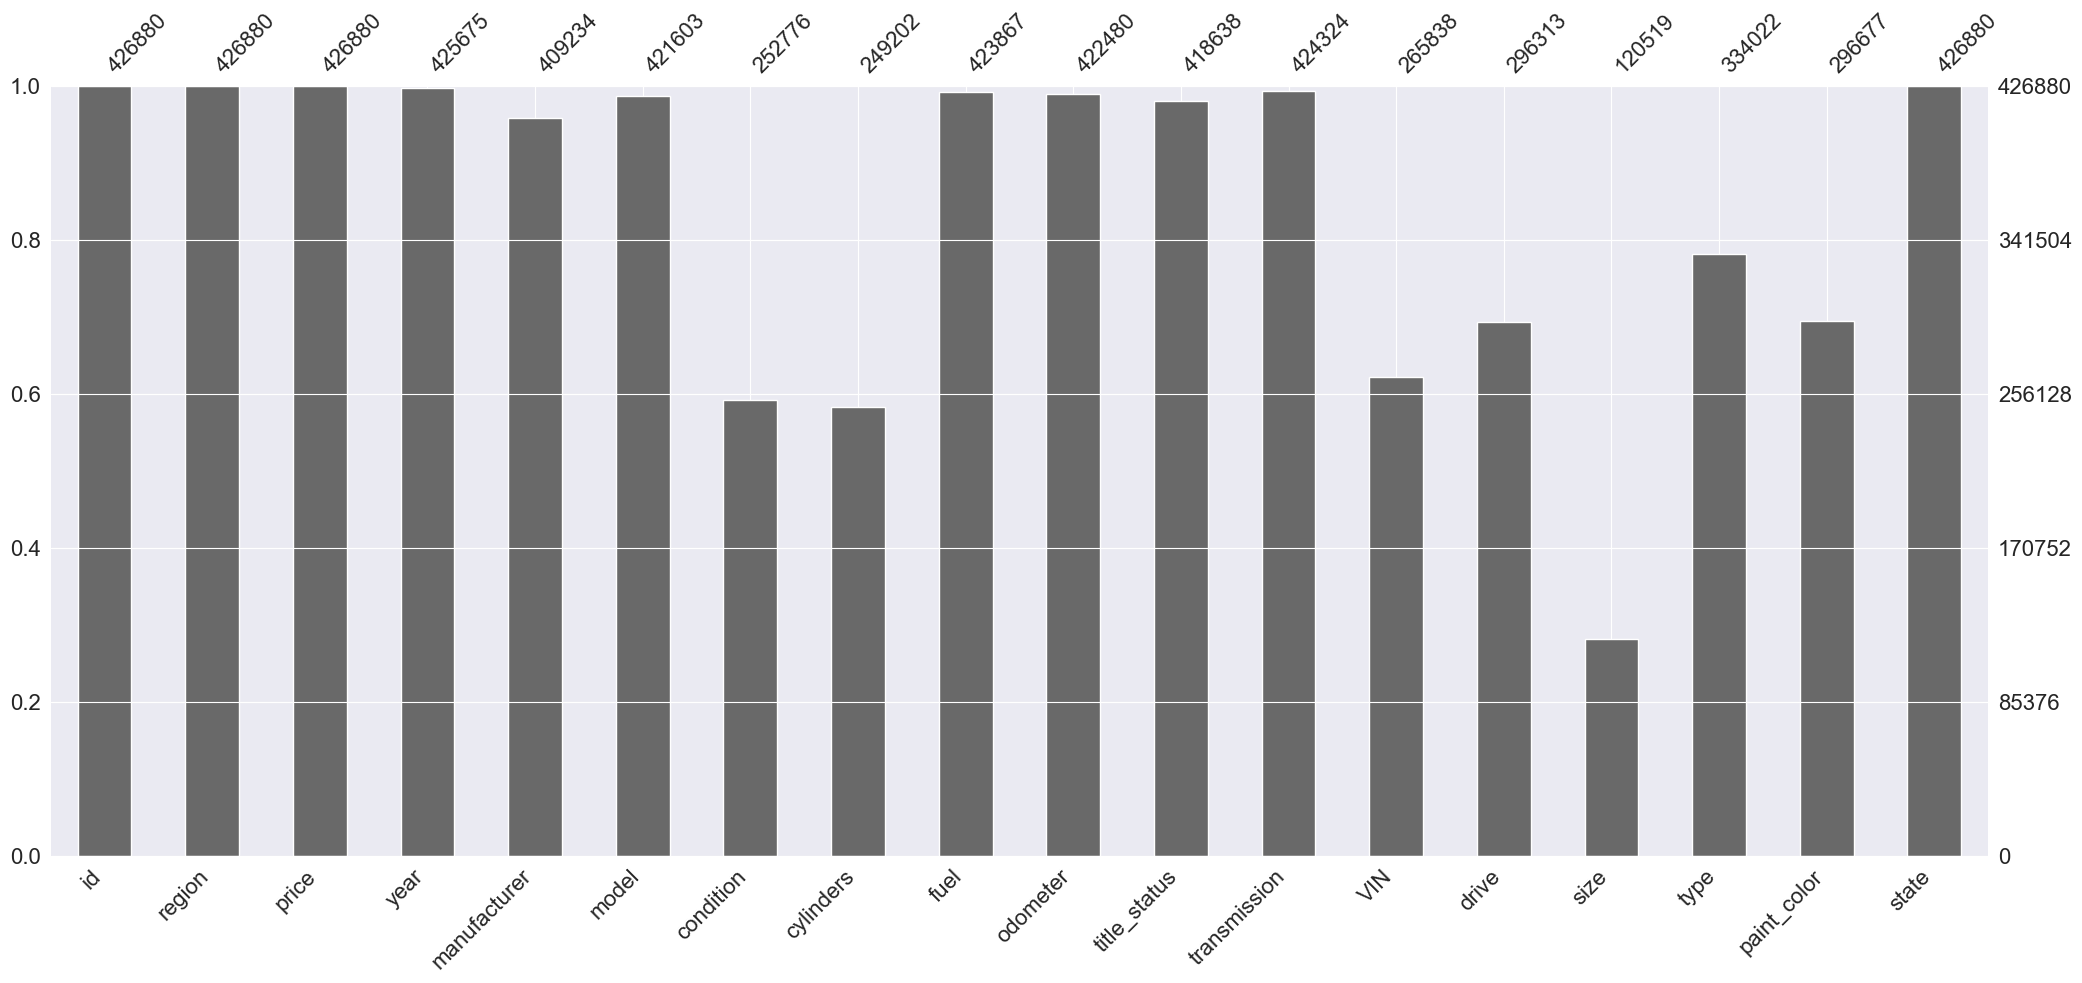

In [65]:
# Id feature presnt
msno.bar(df);

##### From the above plot we can see the 'Size' feature does not have much data, which is going to be dropped

In [66]:
# There are plenty non-numerical( categorical = 14) features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [67]:
# The mean and Std are far away from 0 and 1 respectively
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [68]:
# There are plenty missing or NaN values
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc



##### At this stage we identified those issues.
- categorical features present
- missing value, nan present (drop or fillna)
- normalization or scaling might need to be done as well

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

##### This phase, which is often referred to as “data munging”, prepares the final data set(s) for modeling. Preparing the data includes for example a strategy on how to deal with missing values. In general, the data is usually not that clean as one would expect it to be. But since data of low quality can lead to wrong answers to the business questions, the data preparation step includes also data cleaning.


In [69]:
df['size'].value_counts()

full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: size, dtype: int64

In [70]:
df_clean = df.copy()
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop and resset the index
df_clean=df_clean.reset_index().drop(columns=['index'])

# Dropping NaN values and features with minimal data
df_clean.drop(columns=['size'], inplace=True)
df_clean.dropna(inplace=True)
df_clean.drop_duplicates(inplace=True)

# Converting year feature  to age feature
df_clean['age'] = df_clean['year'].apply(lambda x: datetime.today().year - int(x))
df_clean.drop(columns=['year'], inplace=True)

# Converting float to int, and dropping where the price is zero
df_clean['odometer'] = df_clean['odometer'].apply(lambda x: int(x))
df_clean.drop(df_clean[df_clean['price'] == 0].index,inplace=True)
df_clean.shape

(57925, 17)

In [71]:
# Data correlation
df_clean.head()

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,age
32,7316343444,auburn,27990,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696,clean,other,1GT220CG8CZ231238,4wd,pickup,black,al,11
33,7316304717,auburn,34590,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499,clean,other,1GCVKREH6GZ228691,4wd,pickup,silver,al,7
35,7316257769,auburn,29990,chevrolet,colorado extended cab,good,6 cylinders,gas,17302,clean,other,1GCHTCE37G1186784,4wd,pickup,red,al,7
36,7316133914,auburn,38590,chevrolet,corvette grand sport,good,8 cylinders,gas,30237,clean,other,1G1YR3DW3B5102190,rwd,other,red,al,12
38,7315816316,auburn,32990,jeep,wrangler unlimited sport,good,6 cylinders,gas,30041,clean,other,1C4BJWDG5HL705371,4wd,other,silver,al,6


#### Visualizing the used car dataset, plotting samples of 5000 rows

[Text(0, 0, '6 cylinders'),
 Text(1, 0, '8 cylinders'),
 Text(2, 0, '4 cylinders'),
 Text(3, 0, '10 cylinders'),
 Text(4, 0, '5 cylinders'),
 Text(5, 0, 'other'),
 Text(6, 0, '3 cylinders'),
 Text(7, 0, '12 cylinders')]

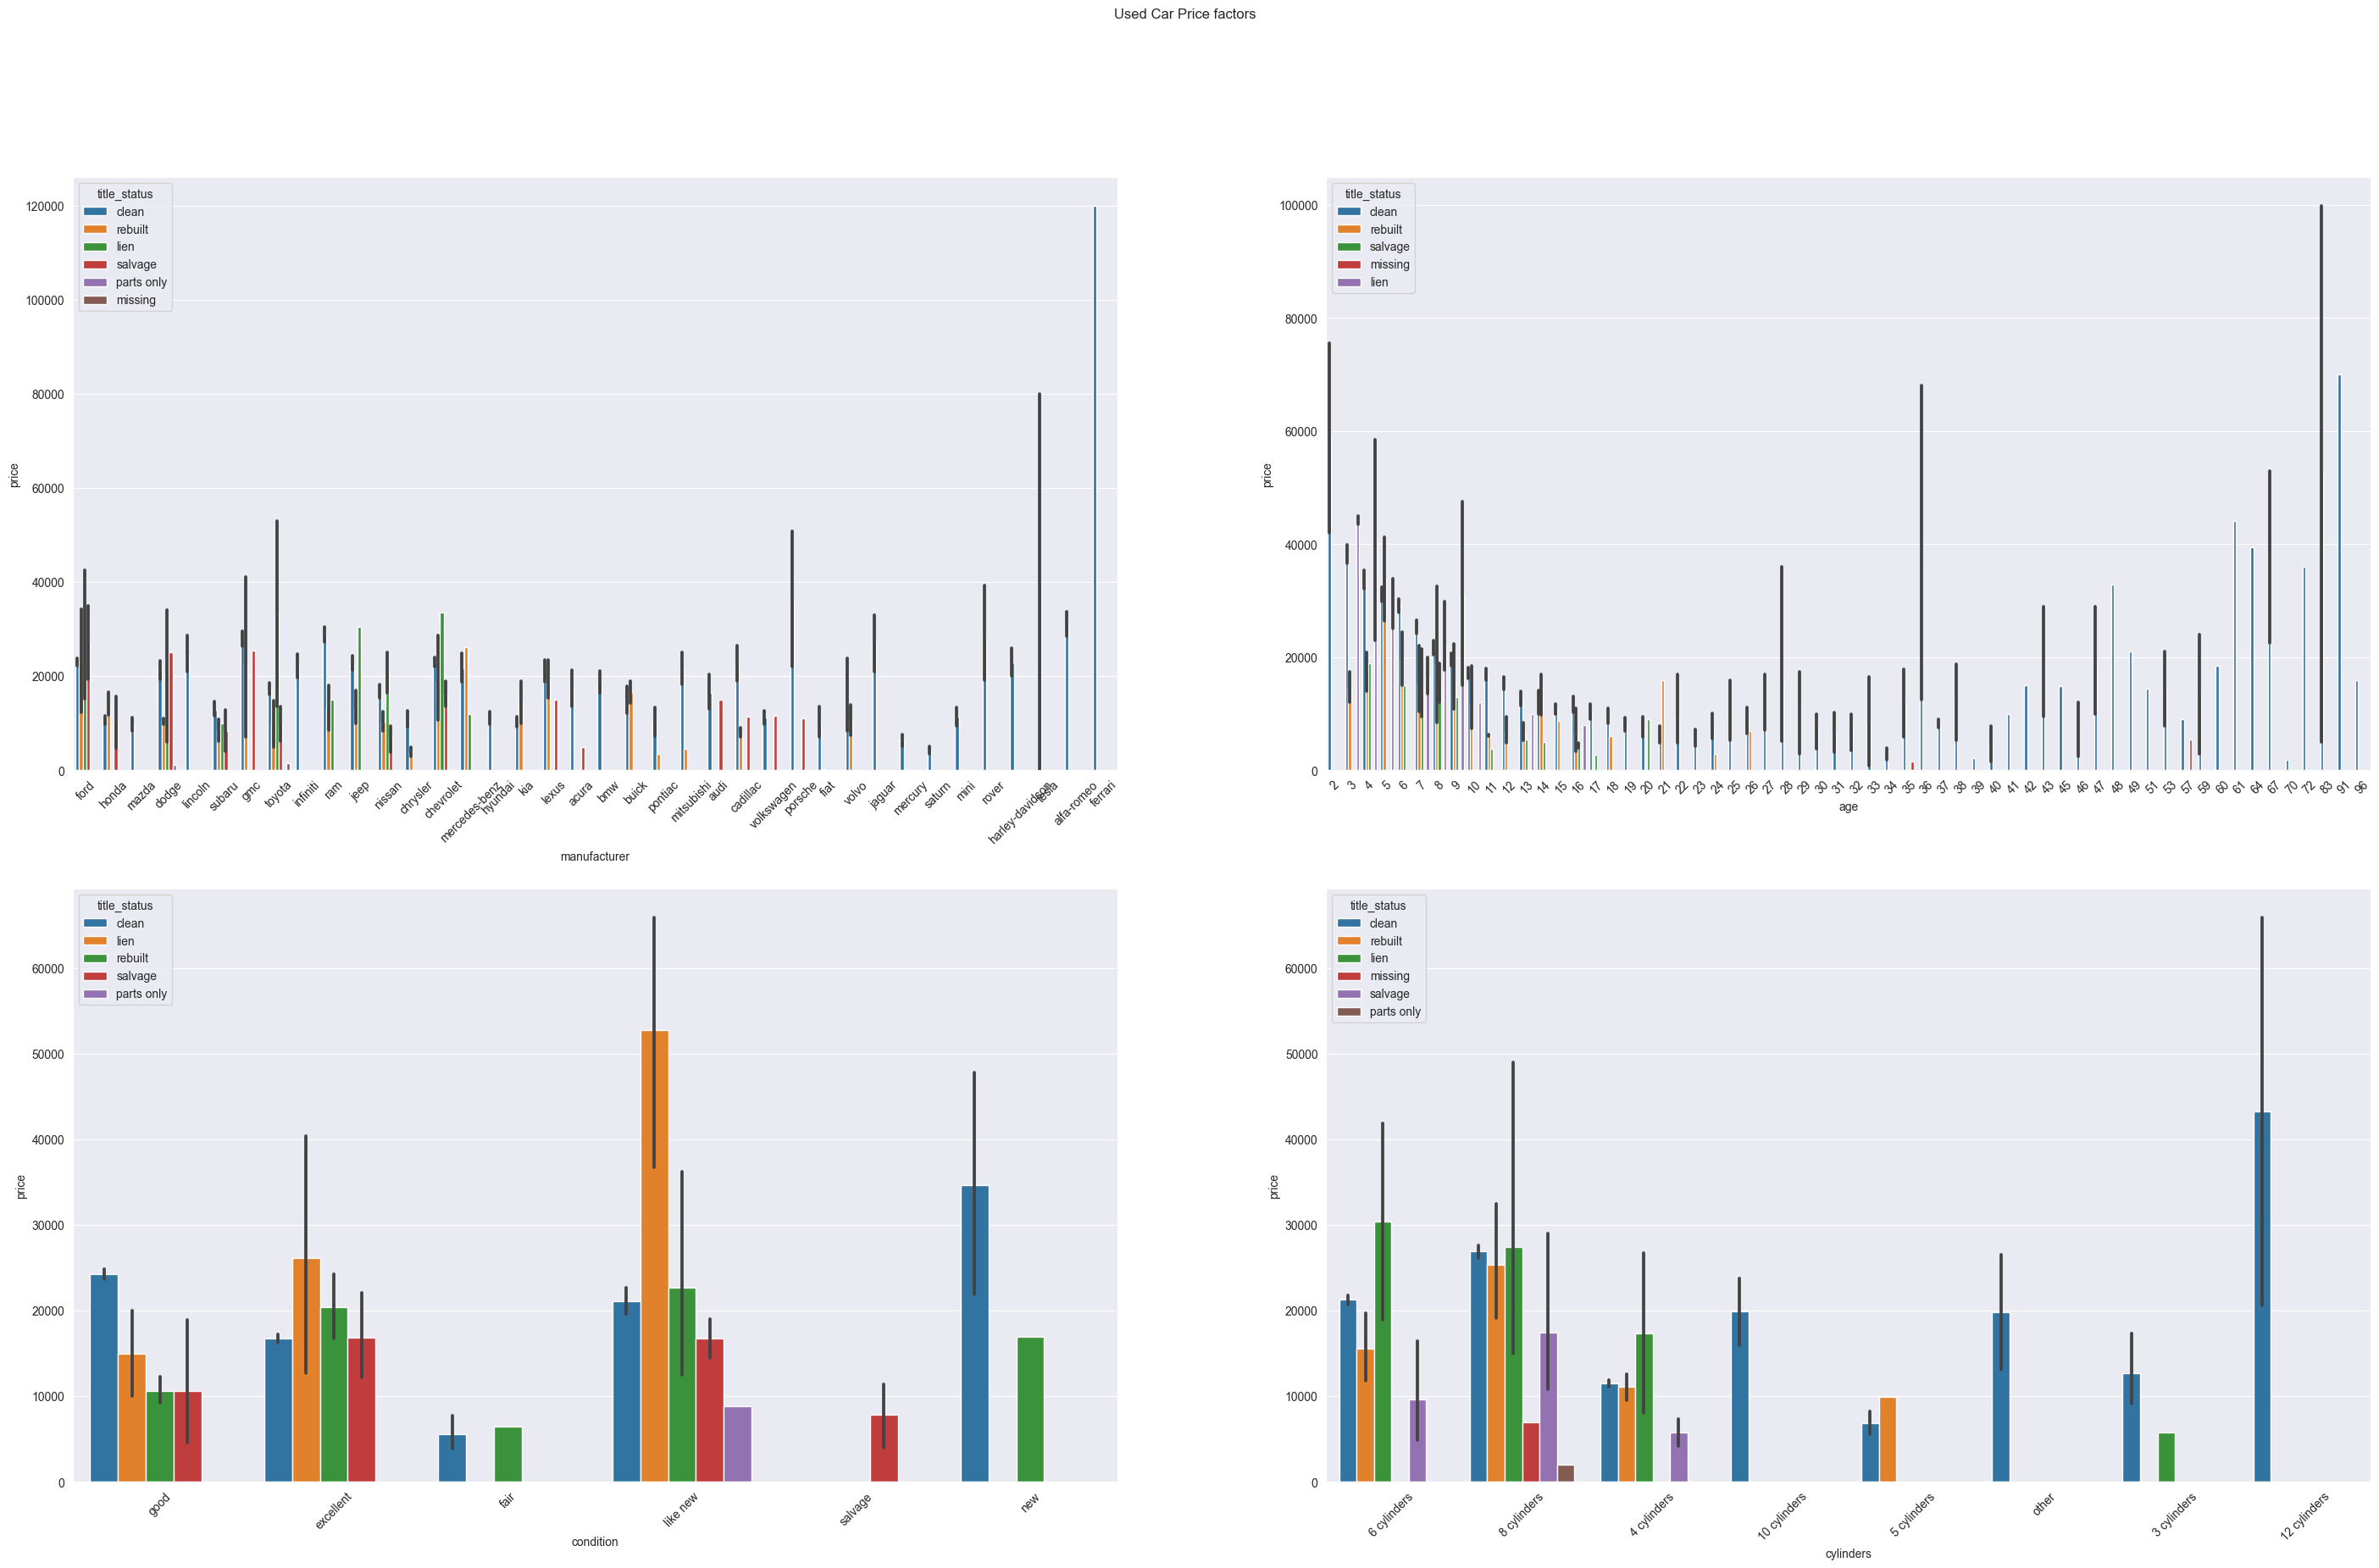

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(35, 20))
fig.suptitle('Used Car Price factors')
coupon_plot_m = sns.barplot(ax=axes[0,0], x='manufacturer', y ='price', hue='title_status', data=df_clean.sample(5000) )
coupon_plot_m.set_xticklabels( coupon_plot_m.get_xticklabels(), rotation=45);


coupon_plot_a = sns.barplot(ax=axes[0,1], x='age', y ='price', hue='title_status', data=df_clean.sample(5000))
coupon_plot_a.set_xticklabels( coupon_plot_a.get_xticklabels(), rotation=45);


coupon_plot_c = sns.barplot(ax=axes[1,0], x='condition', y ='price', hue='title_status', data=df_clean.sample(5000))
coupon_plot_c.set_xticklabels(coupon_plot_c.get_xticklabels(), rotation=45);


coupon_plot_cy = sns.barplot(ax=axes[1,1], x='cylinders', y ='price', hue='title_status', data=df_clean.sample(5000))
coupon_plot_cy.set_xticklabels(coupon_plot_cy.get_xticklabels(),  rotation=45)


###### The above plot shows most common features when buying a car, as the data is random sample, the conclusion is general. What we observe is the price of the car drops with the age, but the cars over 50 years old in god condition as new are pricey.It looks the car with 8 cylinders are mostly in demand in good condition as new, and brands as Jaguar, Aston Martin, Porsche are one of most expensive cars

In [73]:
# Encoding used cars dataset
encoders = []
def label_encoder(cat_columns, df_cars):
    for c in cat_columns:
        le = LabelEncoder().fit(list(df_cars[c].astype(str).values))
        encoders.append(le)
        df_cars[c] = le.transform(list(df_cars[c].astype(str).values))

cat_columns = df_clean.select_dtypes(exclude=np.number).columns.to_list()

df_encd = df_clean.copy()
label_encoder(cat_columns,df_encd)
df_encd.head()

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,age
32,7316343444,16,27990,14,5059,2,6,2,68696,0,2,9638,0,8,0,1,11
33,7316304717,16,34590,7,5124,2,5,2,29499,0,2,8527,0,8,9,1,7
35,7316257769,16,29990,7,1561,2,5,2,17302,0,2,8192,0,8,8,1,7
36,7316133914,16,38590,7,1666,2,6,2,30237,0,2,6732,2,7,8,1,12
38,7315816316,16,32990,20,6110,2,5,2,30041,0,2,833,0,7,9,1,6


In [74]:
df_enc_cp = copy.copy(df_encd)

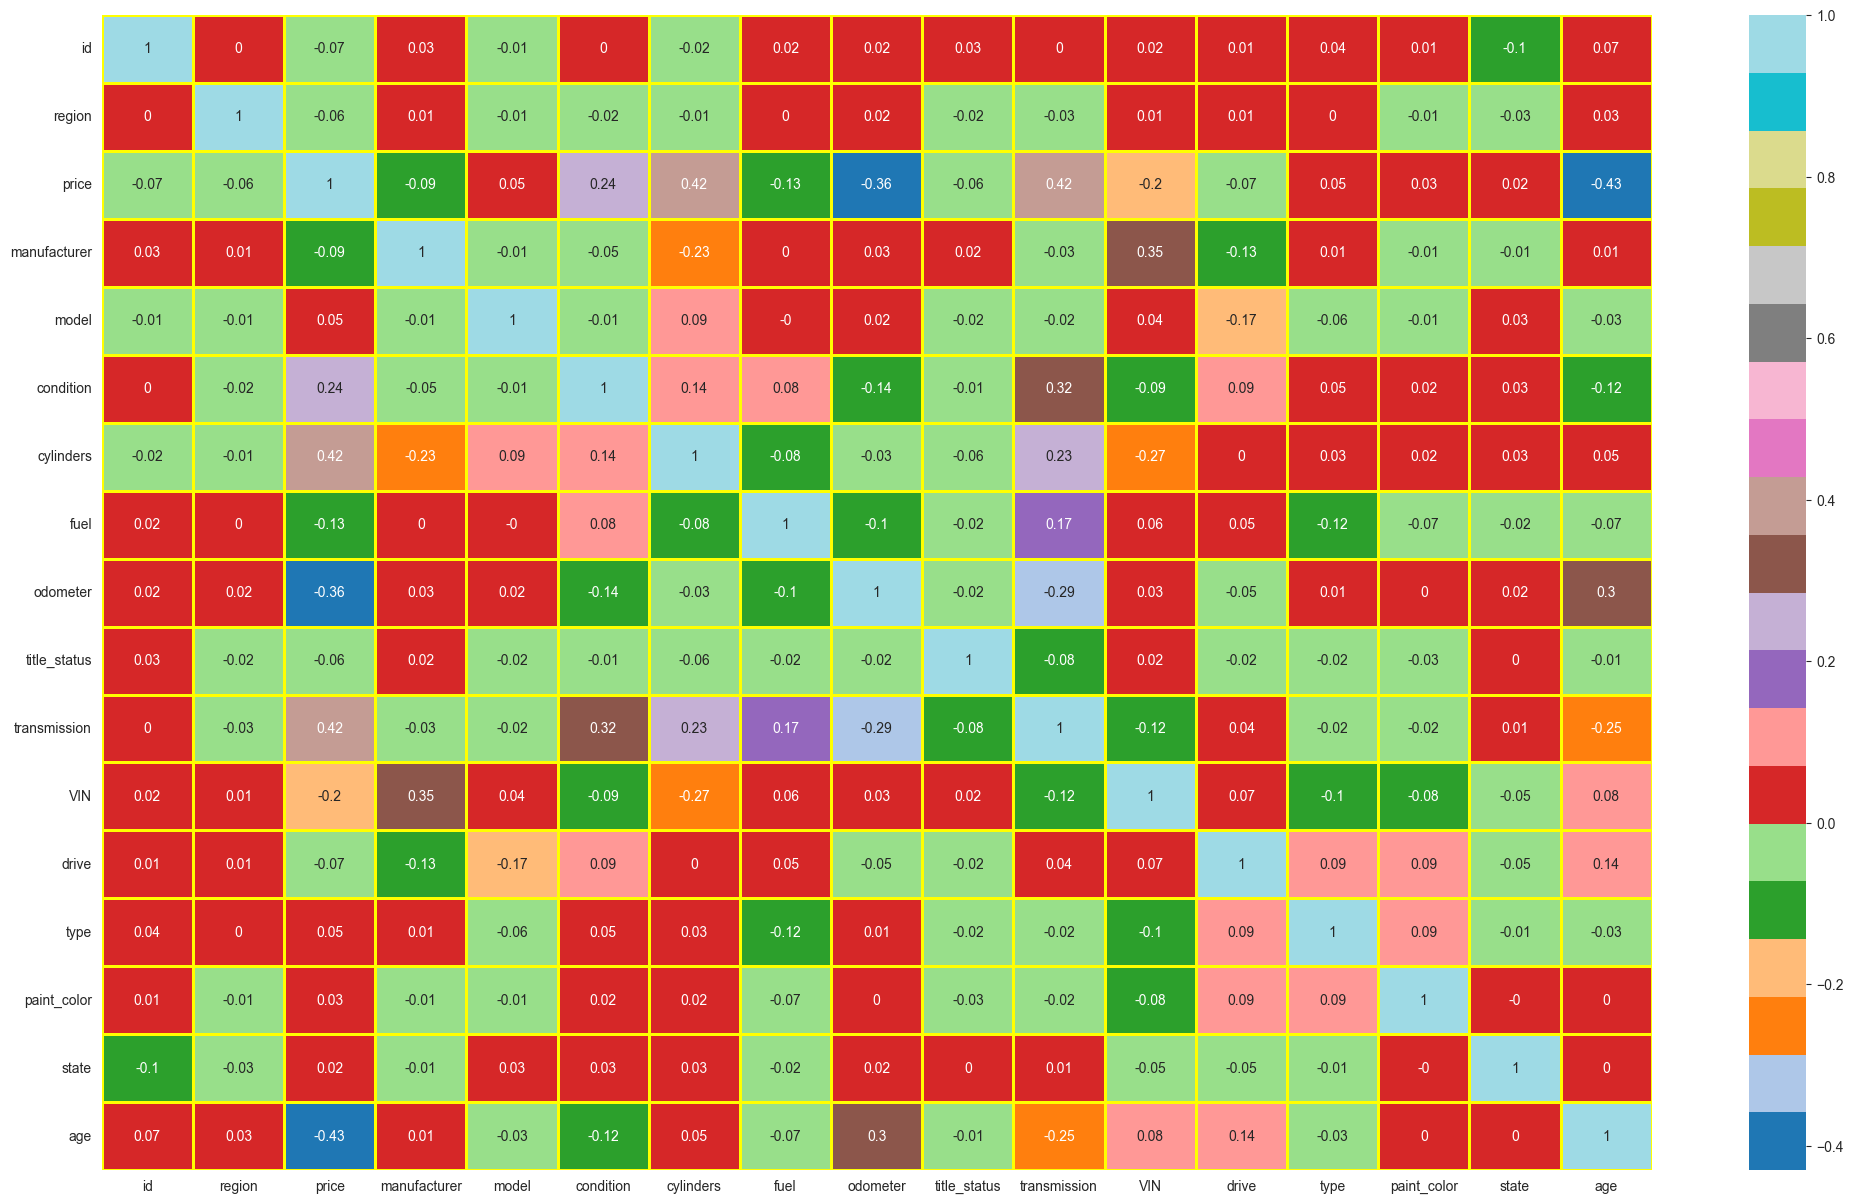

In [75]:
# Used Car dataset correlation
corr =df_encd.corr()
plt.figure(figsize=(25,15))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

##### From the headmap plot we observe positive correlation between Price and cylinders, transmission
##### We also observe some negative correlation between Price and the age, odometer
Correlation matrices: calculating the correlation between every pair of explanatory variables yields indications as to the likelihood that any given couplet of right-hand-side variables are creating multicollinearity problems. Correlation values (off-diagonal elements) of at least 0.4 are sometimes interpreted as indicating a multicollinearity problem, so cylinders, transmission and age features are going to be dropped 

In [76]:
# Correlation of Table
corr_matrix = pd.DataFrame(corr)
corr_matrix = corr_matrix.round(decimals = 2)
create_table(corr_matrix['price'].sort_values(ascending = False).to_frame(),index_title='features',index=True,)

In [77]:
# Dropping features with correlation above +- 0.4
dropping_cols = ['cylinders', 'transmission','age']
#df_encd.drop(columns=dropping_cols, inplace=True)

-4.612032071598797

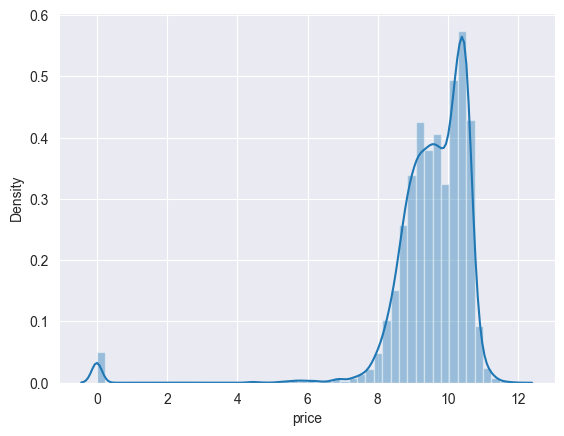

In [78]:
sns.distplot(np.log(df_encd['price']))
np.log(df_encd['price']).skew()

##### Log of price data shows normal distribution with a bit skewed towards left.

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'region'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'manufacturer'}>],
       [<Axes: title={'center': 'model'}>,
        <Axes: title={'center': 'condition'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'fuel'}>],
       [<Axes: title={'center': 'odometer'}>,
        <Axes: title={'center': 'title_status'}>,
        <Axes: title={'center': 'transmission'}>,
        <Axes: title={'center': 'VIN'}>],
       [<Axes: title={'center': 'drive'}>,
        <Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'paint_color'}>,
        <Axes: title={'center': 'state'}>],
       [<Axes: title={'center': 'age'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

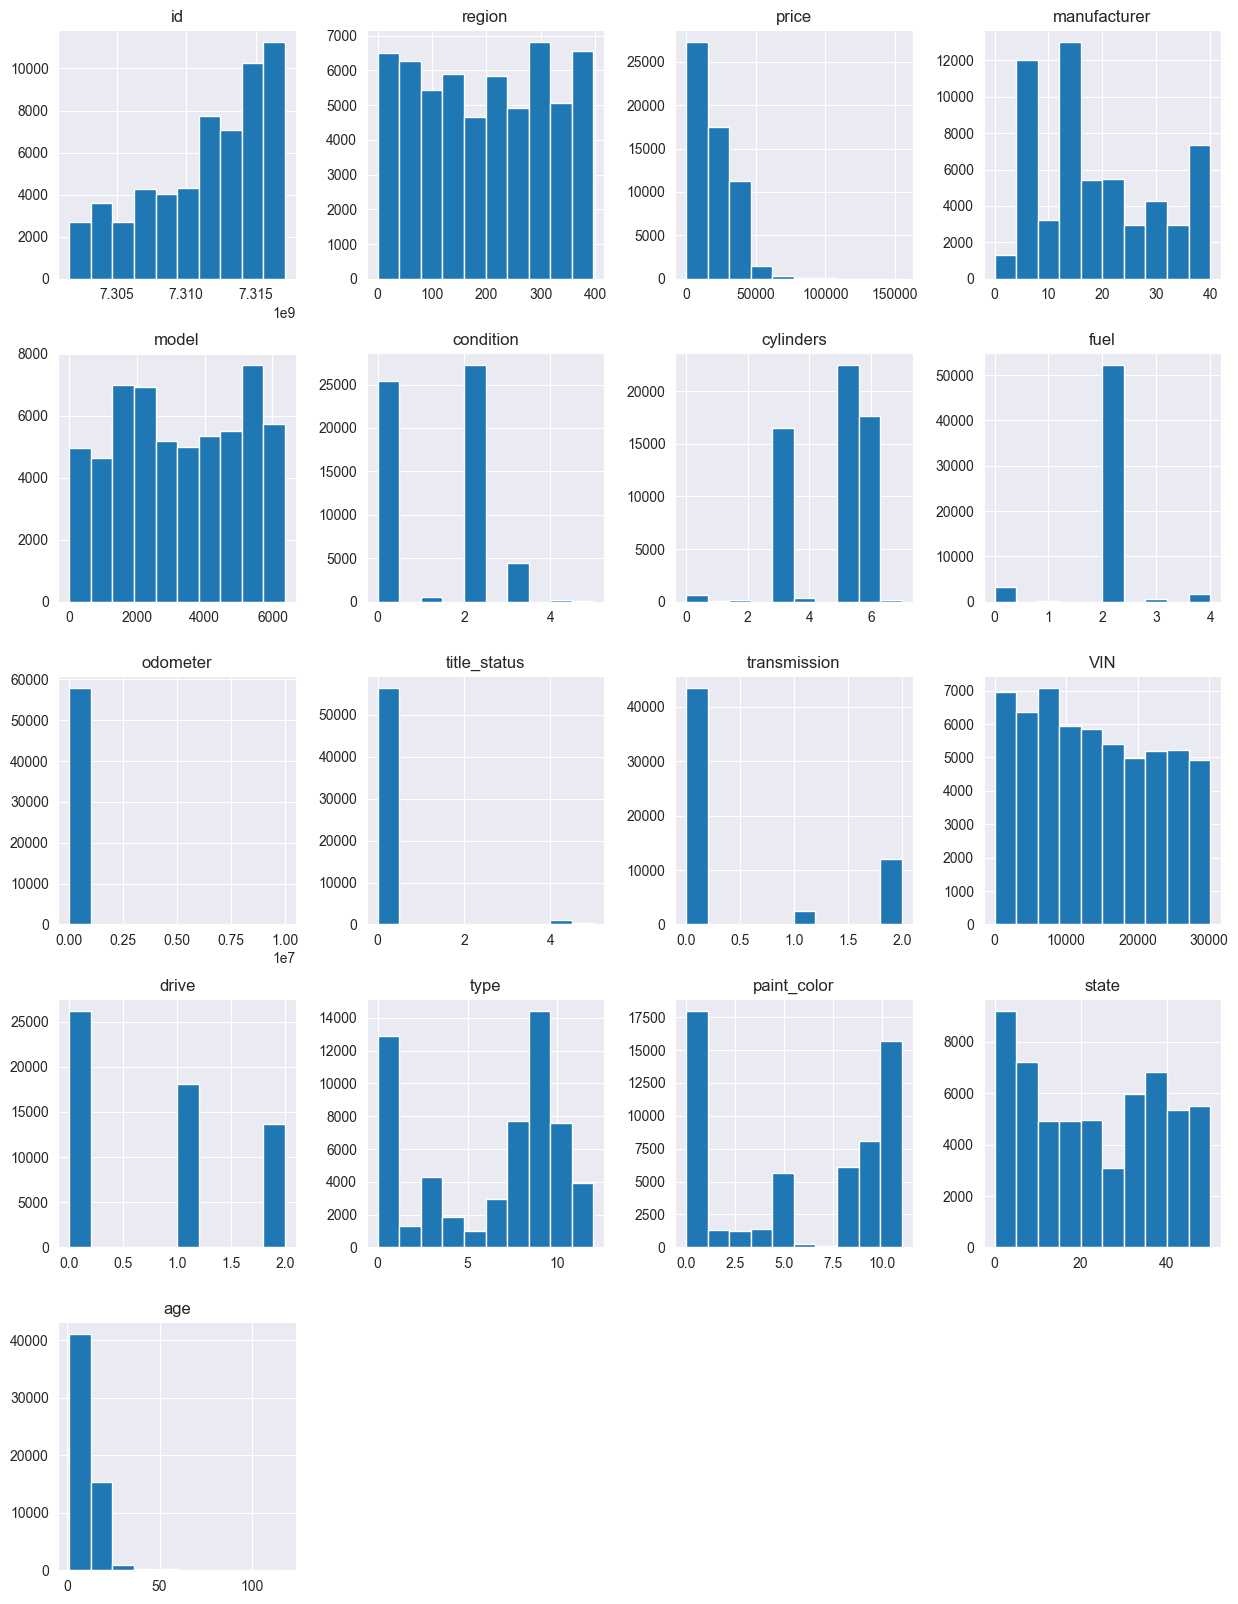

In [79]:
# graphical representation of the distribution of the dataset.
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_encd.hist(ax = ax)

##### Most of the data distribution is a skewed right distribution, also called a positive skew distribution, which means the mean is greater than the median.

In [80]:
# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df_enc_cp)
df_norm =  pd.DataFrame(trans_array)
named_columns = df_enc_cp.columns
numer_couluns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_couluns, named_columns))]
colums = dict(tuples)
df_norm.rename(columns=colums, inplace=True)
df_norm.describe()

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,age
count,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000,57925.000000
mean,-0.009960,-0.014118,-0.013225,-0.018918,-0.005541,-1.912417,-0.026685,-0.116627,-0.010649,-4.989844,-2.784164,-0.001984,-1.031606,-0.766372,-0.797737,-0.020797,0.000207
std,1.003377,1.070629,1.117994,1.152555,0.996292,2.934879,0.975633,1.530038,1.031544,1.290302,4.261763,1.005494,4.192519,2.574342,2.351591,1.113222,1.002650
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.675704,-0.675277,-0.656486,-0.636387,-0.667419,-5.199338,-1.014571,0.021329,-0.689529,-5.199338,-5.199338,-0.679058,-5.199338,-0.583496,-0.634851,-0.695908,-0.773140
50%,-0.007691,0.015055,0.000753,-0.042668,-0.011291,0.485069,0.001255,0.021329,-0.018123,-5.199338,-5.199338,-0.003073,0.284828,-0.045180,0.096753,-0.037646,0.104318
75%,0.657257,0.686350,0.689529,0.680013,0.664970,0.485069,1.025123,0.021329,0.676557,-5.199338,0.741388,0.676888,0.284828,0.454249,1.075207,0.708752,0.618059
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


##### As we can see from the describe pandas method, the mean is 0 and std is 1, so our dataset has a normal distribution

In [81]:
# Correlation of Normalise Dataset
corr_matrix_norm = pd.DataFrame(df_norm.corr())
corr_matrix_norm = corr_matrix_norm.round(decimals = 2)
create_table(corr_matrix_norm['price'].sort_values(ascending = False).to_frame(),index_title='features',index=True,)

##### At this stage we have normalized the dataset of used cars, also we have identified the correlation of the other features to the target or 'Price' feature
##### The positive correlation is with cylinders, transmission, model, condition, and negative with age,odometer and fuel

In [82]:
# Dropping features with correlation above +- 0.4
norm_dropping_cols = ['age', 'odometer']
df_norm.drop(columns=norm_dropping_cols, inplace=True)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

This step is one of the core steps where one tries to find a model which describes the data. In terms of our business problem of predicting the price of a car based on its features, modellig means finding…, Choose and apply appropriate algorithms and methods to the data.

##### Create Train/Test split

In [83]:
#Normalized data
X_norm = df_norm.drop('price', axis = 1)
y_norm = df_norm['price']
X_norm_train, X_norm_val, y_norm_train, y_norm_val = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)
print(X_norm_train.shape)
print(X_norm_val.shape)

(38809, 14)
(19116, 14)


In [84]:
# Factorized data
X_encd = df_encd.drop('price', axis = 1)
scaler = StandardScaler()
X_encd = scaler.fit_transform(X_encd)
y_encd = df_encd['price']
X_encd_train, X_encd_val, y_encd_train, y_encd_val = train_test_split(X_encd, y_encd, test_size=0.33, random_state=42)
print(X_encd_val.shape)
print(X_encd_val.shape)

(19116, 16)
(19116, 16)


##### Creating baselines

In [85]:
baseline_train = np.ones(shape = y_encd_train.shape)*y_encd_train.mean()
baseline_test = np.ones(shape = y_encd_val.shape)*y_encd_val.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_encd_train)
mse_baseline_test = mean_squared_error(baseline_test, y_encd_val)

print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')

(38809,) (19116,)
Baseline for training data: 186429395.48002726
Baseline for testing data: 187398333.81127775


##### Permutation feature importance

In [86]:
model = Ridge(alpha=1e-2).fit(X_encd_train, y_encd_train)
r_sq_encd = model.score(X_encd_val, y_encd_val)
print(f"R-squared: {round(r_sq_encd,2)* 100}%")

R-squared: 51.0%


In [87]:
model_norm = Ridge(alpha=1e-2).fit(X_norm_train, y_norm_train)
r_sq_norm = model_norm.score(X_norm_val, y_norm_val)

print(f"Norm R-squared: {round(r_sq_norm,2) * 100}%")

Norm R-squared: 25.0%


##### Normalized data model has better R-squared value of 15%

In [88]:
# The permutation_importance function calculates the feature importance of estimators for a given dataset.
r = permutation_importance(model, X_encd_val, y_encd_val, n_repeats=30, random_state=0)
permutations = {}
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_encd.columns[i]:<8} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
        permutations[df_encd.columns[i]]= [r.importances_mean[i],r.importances_std[i]]

condition 0.244 +/- 0.004
state    0.201 +/- 0.004
fuel     0.083 +/- 0.002
title_status 0.078 +/- 0.002
cylinders 0.067 +/- 0.002
model    0.011 +/- 0.001
VIN      0.003 +/- 0.000
transmission 0.003 +/- 0.000
id       0.002 +/- 0.000
odometer 0.002 +/- 0.000
region   0.002 +/- 0.000
price    0.000 +/- 0.000
type     0.000 +/- 0.000


In [89]:
permutation_data = pd.DataFrame.from_dict(permutations, orient='index', columns=['mean', 'std'])
res_perm_data = permutation_data.reset_index()
permutation_data.reset_index()

,index,mean,std
0,condition,0.243864,0.004071
1,state,0.201396,0.003699
2,fuel,0.082685,0.002271
3,title_status,0.078045,0.001837
4,cylinders,0.067415,0.001574
5,model,0.011080,0.000794
6,VIN,0.003289,0.000369
7,transmission,0.002691,0.000318
8,id,0.002384,0.000361
9,odometer,0.002333,0.000290


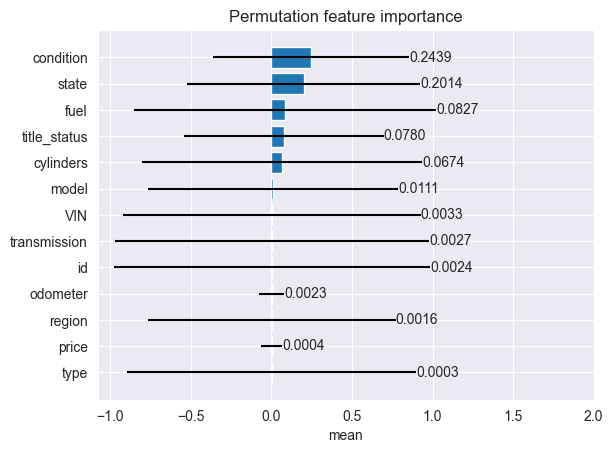

In [90]:
permutation_data.reset_index()
error = np.random.rand(res_perm_data['index'].shape[0])
fig, ax = plt.subplots()

hbars = ax.barh(res_perm_data['index'], res_perm_data['mean'], xerr=error, align='center')
ax.set_yticks(res_perm_data['index'], labels=res_perm_data['index'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('mean')
ax.set_title('Permutation feature importance')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.4f')
ax.set_xlim(right=2)  # adjust xlim to fit labels

plt.show()

In [91]:
# Permutation for Normalized data
r_n = permutation_importance(model_norm, X_norm_val, y_norm_val, n_repeats=30, random_state=0)
permutations_n = {}
for i in r_n.importances_mean.argsort()[::-1]:
    if r_n.importances_mean[i] - 2 * r_n.importances_std[i] > 0:
        print(f"{df_norm.columns[i]:<8} {r_n.importances_mean[i]:.3f} +/- {r_n.importances_std[i]:.3f}")
        permutations_n[df_norm.columns[i]] = [r_n.importances_mean[i], r_n.importances_std[i]]

condition 0.173 +/- 0.003
title_status 0.103 +/- 0.002
cylinders 0.036 +/- 0.002
model    0.029 +/- 0.001
id       0.008 +/- 0.001
transmission 0.007 +/- 0.001
VIN      0.005 +/- 0.001
region   0.003 +/- 0.000
type     0.001 +/- 0.000
drive    0.001 +/- 0.000
paint_color 0.000 +/- 0.000


In [92]:
permutation_data_n = pd.DataFrame.from_dict(permutations_n, orient='index', columns=['mean', 'std'])
res_perm_data_n = permutation_data_n.reset_index()
permutation_data_n.reset_index()

,index,mean,std
0,condition,0.173316,0.003134
1,title_status,0.102724,0.002410
2,cylinders,0.035648,0.001850
3,model,0.029062,0.001353
4,id,0.007735,0.000779
5,transmission,0.007481,0.000823
6,VIN,0.005346,0.000686
7,region,0.003033,0.000416
8,type,0.001242,0.000287
9,drive,0.000764,0.000258


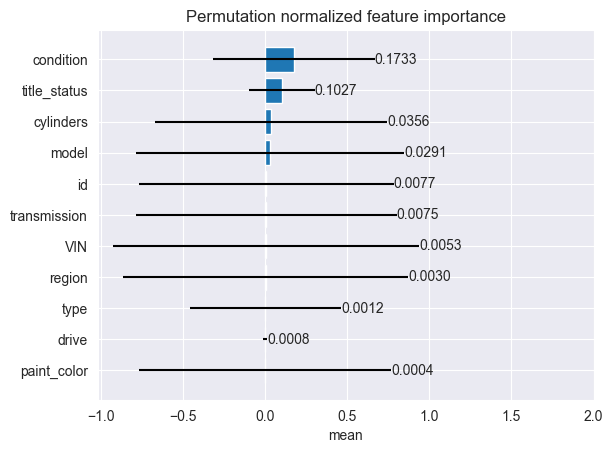

In [93]:
error_n = np.random.rand(res_perm_data_n['index'].shape[0])
fig, ax = plt.subplots()

hbars_n = ax.barh(res_perm_data_n['index'], res_perm_data_n['mean'], xerr=error_n, align='center')
ax.set_yticks(res_perm_data_n['index'], labels=res_perm_data_n['index'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('mean')
ax.set_title('Permutation normalized feature importance')

# Label with specially formatted floats
ax.bar_label(hbars_n, fmt='%.4f')
ax.set_xlim(right=2)  # adjust xlim to fit labels

plt.show()

##### We have selected the following features for our models
- fuel
- cylinder
- model
- condition
- title_status

##### Model preparation and selecting the features

In [94]:
model_features = ['fuel', 'cylinders', 'model', 'condition',  'title_status']

model_df = df_clean[model_features]
model_df.reset_index(drop=['index'], inplace=True)
le = LabelEncoder().fit(list(model_df['model'].astype(str).values))
model_df['model'] = le.transform(list(model_df['model'].astype(str).values))

X = model_df
y = df_clean['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_val.shape)


(38809, 5)
(19116, 5)


##### Choosing the best polynomial degree of the model

In [95]:
# Work around for a LabelEncoder with pipe 
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [96]:
train_mses = []
test_mses = []
r_squared = []
complex_num = 21
for i in range(1, complex_num):
    poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(include_bias = False, degree = i), make_column_selector(dtype_include=np.number)),
                                                (ModifiedLabelEncoder(), ['fuel']),
                                                (ModifiedLabelEncoder(), ['cylinders']),
                                                (OrdinalEncoder(categories = [['lien','parts only', 'missing', 'salvage', 'rebuilt', 'clean']]), ['title_status']),
                                                (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']))


    pipe = Pipeline([('transformer', poly_ordinal_ohe), ('linreg', LinearRegression())])

    #fit on train
    pipe.fit(X_train, y_train)
    R_square = pipe.score(X_train, y_train)

    #predict on train and test
    p1 = pipe.predict(X_train)
    p2 = pipe.predict(X_val)

    #create MSEs for train and test sets
    train_mses.append(round(mean_squared_error(y_train, p1),2))
    test_mses.append(round(mean_squared_error(y_val, p2),2))
    r_squared.append(round(R_square,2))

pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=20,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000282EFA70850>),
                                                 ('modifiedlabelencoder-1',
                                                  ModifiedLabelEncoder(),
                                                  ['fuel']),
                                                 ('modifiedlabelencoder-2',
                                                  ModifiedLabelEncoder(),
                                                  ['cylinders']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['lien',
                                                                              'parts '
                                                                              'only',
                                                                              'missing',
                                                                              'salvage',
                                                                              'rebuilt',
                                                                              'clean']]),
                                                  ['title_status']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition'])])),
                ('linreg', LinearRegression())])

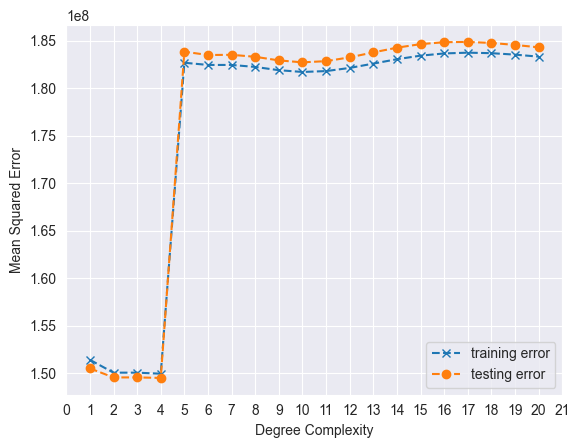

In [97]:
plt.plot(range(1, complex_num), train_mses, '--x', label = 'training error')
plt.plot(range(1, complex_num), test_mses, '--o', label = 'testing error')
plt.xticks( range(0, complex_num+1), range(0, complex_num+1))

plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [98]:
best_complexity = test_mses.index(min(test_mses)) + 1
best_mse = min(test_mses)
best_rsq2 = max(r_squared) 

# Answer check
print(f'The best degree polynomial model is:  {best_complexity}')
print(f'The smallest mean squared error on the test data is : {best_mse: .2f}')
print(f'The best value of the R-sq of the model, as a good fit is: {best_rsq2: .2f}')

The best degree polynomial model is:  4
The smallest mean squared error on the test data is :  149521613.73
The best value of the R-sq of the model, as a good fit is:  0.20


In [122]:
# Create polynomial object with 4 degree
poly_ordinal_ohe_4 = make_column_transformer((PolynomialFeatures(include_bias = False, degree = 4), make_column_selector(dtype_include=np.number)),
                                           (ModifiedLabelEncoder(), ['fuel']),
                                           (ModifiedLabelEncoder(), ['cylinders']),
                                           (OrdinalEncoder(categories = [['lien','parts only', 'missing', 'salvage', 'rebuilt', 'clean']]), ['title_status']),
                                           (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']))

In [100]:
df_clean

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,age
32,7316343444,auburn,27990,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696,clean,other,1GT220CG8CZ231238,4wd,pickup,black,al,11
33,7316304717,auburn,34590,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499,clean,other,1GCVKREH6GZ228691,4wd,pickup,silver,al,7
35,7316257769,auburn,29990,chevrolet,colorado extended cab,good,6 cylinders,gas,17302,clean,other,1GCHTCE37G1186784,4wd,pickup,red,al,7
36,7316133914,auburn,38590,chevrolet,corvette grand sport,good,8 cylinders,gas,30237,clean,other,1G1YR3DW3B5102190,rwd,other,red,al,12
38,7315816316,auburn,32990,jeep,wrangler unlimited sport,good,6 cylinders,gas,30041,clean,other,1C4BJWDG5HL705371,4wd,other,silver,al,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426859,7301952155,wyoming,48590,cadillac,xt6 premium luxury,good,6 cylinders,gas,7701,clean,other,1GYKPCRSXLZ181516,fwd,other,black,wy,3
426860,7301951544,wyoming,39990,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,41664,clean,automatic,JN8AZ2NE3H9156734,4wd,other,black,wy,6
426866,7301949190,wyoming,32990,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612,clean,automatic,JN8AZ2NF5G9611039,rwd,other,black,wy,7
426874,7301591199,wyoming,33590,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814,clean,automatic,JTHBZ1BLXJA012999,rwd,sedan,white,wy,5


#### Regression Models

##### Linear regression

In [123]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)
coef_list        = []
r2_list          = []
mse_list         = []
scores_rig_train = []
scores_rig       = []

linreg = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_train, y_train)
coef_list.append(list(np.round(linreg.named_steps['linreg'].coef_, 2)))
scores_rig_train.append(linreg.score(X_train, y_train,))
scores_rig.append(linreg.score(X_val, y_val,))

r2_list.append(r2_score(y_val, linreg.predict(X_val)))
mse_list.append(mean_squared_error(y_val, linreg.predict(X_val)))

len(coef_list)
# Evaluate the model on the test set with the selected features
#print(f"Model score with selected features: {lasso.score(X_test_selected, y_test):.3f}")
score_skfold_lr = cross_val_score(linreg, X, y, cv=skfold)
print(f"Model Train LinearRegression score with selected features:: {linreg.score(X_train, y_train,):.3f}")
print(f"Model LinearRegression score with selected features: {linreg.score(X_val, y_val,):.3f}")
print(f"Accuracy scores for each fold: {score_skfold_lr}")
print(f"Model R2: {r2_score(y_val, linreg.predict(X_val)):.3f}")
print(f"MSE: {mean_squared_error(y_val, linreg.predict(X_val)):.4f}")
coeff_lrg = pd.DataFrame(X_train.columns)
coeff_lrg['Coefficient Estimate'] = pd.Series(coef_list[0])
coeff_lrg.sort_values(by=['Coefficient Estimate'],  inplace=True)
coeff_lrg.rename(columns={0:'features'}, inplace=True)
coeff_lrg

Model Train LinearRegression score with selected features:: 0.196
Model LinearRegression score with selected features: 0.202
Accuracy scores for each fold: [0.19700635 0.19730614 0.19839797]
Model R2: 0.202
MSE: 149521613.7322


,features,Coefficient Estimate
1,cylinders,-20668.78
3,condition,-18182.70
4,title_status,-1474.58
0,fuel,731.71
2,model,38391.90


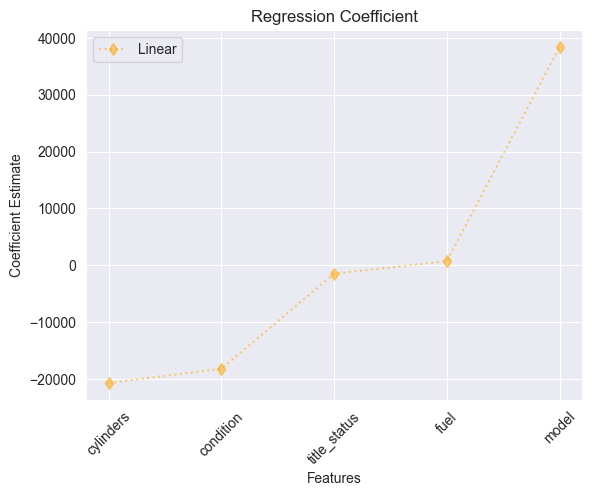

In [102]:
plt.plot(coeff_lrg['features'],coeff_lrg['Coefficient Estimate'],alpha=0.5,linestyle='dotted',marker='d',markersize=6,color='orange',label=f"Linear")
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Coefficient Estimate')
plt.title('Regression Coefficient')
plt.legend()
plt.show()

##### Ridge regularization

In [124]:
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas = alphas))])
ridge1.fit(X_train, y_train)
coef_list.append(list(np.round(ridge1.named_steps['ridgereg'].coef_, 2)))
scores_rig_train.append(ridge1.score(X_train, y_train,))
scores_rig.append(ridge1.score(X_val, y_val,))
r2_list.append(r2_score(y_val, ridge1.predict(X_val)))
mse_list.append(mean_squared_error(y_val, ridge1.predict(X_val)))

len(coef_list)
# Evaluate the model on the test set with the selected features
#print(f"Model score with selected features: {lasso.score(X_test_selected, y_test):.3f}")
score_skfold_rr = cross_val_score(ridge1, X, y, cv=skfold)
print(f"Model Ridge with alfa ={ridge1.named_steps['ridgereg'].alpha_} ")
print(f"Model Train Ridge score with selected features:: {ridge1.score(X_train, y_train,):.3f}")
print(f"Model Ridge score with selected features: {ridge1.score(X_val, y_val,):.3f}")
print(f"Accuracy scores for each fold: {score_skfold_rr}")
print(f"Model R2: {r2_score(y_val, ridge1.predict(X_val)):.3f}")
print(f"MSE: {mean_squared_error(y_val, ridge1.predict(X_val)):.4f}")
coeff_lrg_ridge = pd.DataFrame(X_train.columns)
coeff_lrg_ridge['Coefficient Estimate'] = pd.Series(coef_list[0])
coeff_lrg_ridge.sort_values(by=['Coefficient Estimate'],  inplace=True)
coeff_lrg_ridge.rename(columns={0:'features'}, inplace=True)
coeff_lrg_ridge

Model Ridge with alfa =0.1 
Model Train Ridge score with selected features:: 0.196
Model Ridge score with selected features: 0.202
Accuracy scores for each fold: [0.19702451 0.19729649 0.19838812]
Model R2: 0.202
MSE: 149519086.3217


,features,Coefficient Estimate
1,cylinders,-20668.78
3,condition,-18182.70
4,title_status,-1474.58
0,fuel,731.71
2,model,38391.90


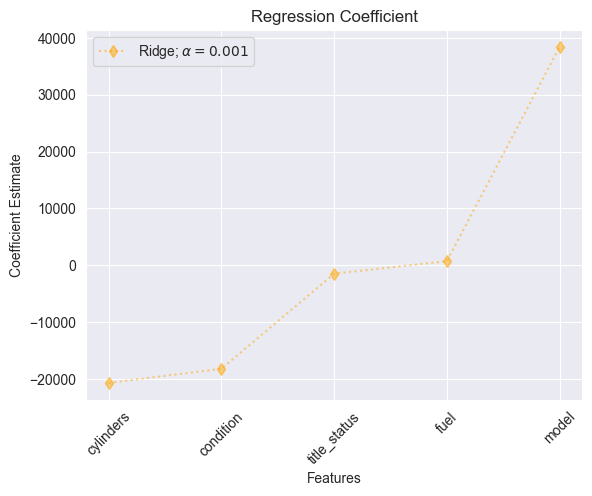

In [104]:
plt.plot(coeff_lrg_ridge['features'],coeff_lrg_ridge['Coefficient Estimate'],alpha=0.5,linestyle='dotted',marker='d',markersize=6,color='orange',label=fr"Ridge; $\alpha = {alphas[0]}$")
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Coefficient Estimate')
plt.title('Regression Coefficient')
plt.legend()
plt.show()

##### Lasso regularization

In [125]:
lasso = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('lasso_reg', Lasso(random_state = 42))])
lasso.fit(X_train, y_train)
coef_list.append(list(np.round(lasso.named_steps['lasso_reg'].coef_, 2)))
scores_rig_train.append(lasso.score(X_train, y_train,))
scores_rig.append(lasso.score(X_val, y_val,))
r2_list.append(r2_score(y_val, lasso.predict(X_val)))
mse_list.append(mean_squared_error(y_val, lasso.predict(X_val)))

len(coef_list)
# Evaluate the model on the test set with the selected features
#print(f"Model score with selected features: {lasso.score(X_test_selected, y_test):.3f}")
idx = mse_list.index((min(mse_list)))
score_skfold_lr = cross_val_score(lasso, X, y, cv=skfold)
print(f"Model Lasso")
print(f"Model Train Lasso score with selected features:: {lasso.score(X_train, y_train,):.3f}")
print(f"Model Lasso score with selected features: {lasso.score(X_val, y_val,):.3f}")
print(f"Accuracy scores for each fold: {score_skfold_lr}")
print(f"Model R2: {r2_score(y_val, lasso.predict(X_val)):.3f}")
print(f"MSE: {mean_squared_error(y_val, lasso.predict(X_val)):.4f}")
coeff_lrg_lasso = pd.DataFrame(X_train.columns)
coeff_lrg_lasso['Coefficient Estimate'] = pd.Series(coef_list[1])
coeff_lrg_lasso.sort_values(by=['Coefficient Estimate'],  inplace=True)
coeff_lrg_lasso.rename(columns={0:'features'}, inplace=True)
coeff_lrg_lasso

Model Lasso
Model Train Lasso score with selected features:: 0.195
Model Lasso score with selected features: 0.202
Accuracy scores for each fold: [0.19682981 0.19681533 0.19789038]
Model R2: 0.202
MSE: 149559996.7902


,features,Coefficient Estimate
1,cylinders,-19261.38
3,condition,-17233.17
4,title_status,-1474.66
0,fuel,430.18
2,model,36337.76


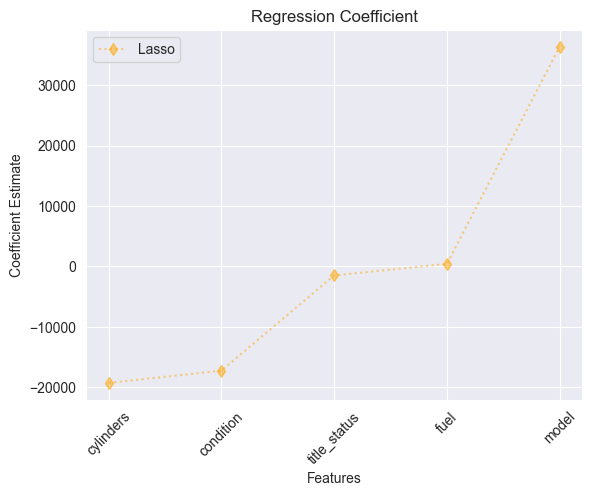

In [106]:
plt.plot(coeff_lrg_lasso['features'],coeff_lrg_lasso['Coefficient Estimate'],alpha=0.5,linestyle='dotted',marker='d',markersize=6,color='orange',label=f"Lasso")
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Coefficient Estimate')
plt.title('Regression Coefficient')
plt.legend()
plt.show()

##### RandomForestRegressor

In [126]:
rfr = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(max_depth=2, random_state=0))])
rfr.fit(X_train, y_train)
scores_rig_train.append(rfr.score(X_train, y_train,))
scores_rig.append(rfr.score(X_val, y_val,))
r2_list.append(r2_score(y_val, rfr.predict(X_val)))
mse_list.append(mean_squared_error(y_val, rfr.predict(X_val)))

# Evaluate the model on the test set with the selected features
#print(f"Model score with selected features: {lasso.score(X_test_selected, y_test):.3f}")
idx = mse_list.index((min(mse_list)))
score_skfold_lr = cross_val_score(rfr, X, y, cv=skfold)
print(f"Model RandomForestRegressor")
print(f"Model Train RandomForestRegressor score with selected features:: {rfr.score(X_train, y_train,):.3f}")
print(f"Model RandomForestRegressor score with selected features: {rfr.score(X_val, y_val,):.3f}")
print(f"Accuracy scores for each fold: {score_skfold_lr}")
print(f"Model R2: {r2_score(y_val, rfr.predict(X_val)):.3f}")
print(f"MSE: {mean_squared_error(y_val, rfr.predict(X_val)):.4f}")
rfr

Model RandomForestRegressor
Model Train RandomForestRegressor score with selected features:: 0.207
Model RandomForestRegressor score with selected features: 0.218
Accuracy scores for each fold: [0.20907185 0.20881013 0.21335575]
Model R2: 0.218
MSE: 146466886.4583


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000282EFA13070>),
                                                 ('modifiedlabelencoder-1',
                                                  ModifiedLabelEncoder(),
                                                  ['fuel']),
                                                 ('modifiedlabelencoder-2',
                                                  ModifiedLabelEncoder(),
                                                  ['cylinders']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['lien',
                                                                              'parts '
                                                                              'only',
                                                                              'missing',
                                                                              'salvage',
                                                                              'rebuilt',
                                                                              'clean']]),
                                                  ['title_status']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition'])])),
                ('scaler', StandardScaler()),
                ('rfr', RandomForestRegressor(max_depth=2, random_state=0))])

##### GridSearchCV

In [108]:
# Define a grid of hyperparameters for tuning
param_grid = {
    'clf__alpha'     : [0.1,1,10,0.01],
    'clf__tol'       : [0.0001,0.001]
}


In [127]:
# Create a GridSearchCV object to find the best parameters
pipeline_grid = Pipeline([('transformer', poly_ordinal_ohe_4), ('scaler', MinMaxScaler()), ('clf', HuberRegressor())])
shuffle_split = StratifiedShuffleSplit(test_size=0.25,train_size=0.75,n_splits=35,random_state=87951)
grid_search= GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(degree=4,
                                                                                            include_bias=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000282EFA13070>),
                                                                        ('modifiedlabelencoder-1',
                                                                         ModifiedLabelEncoder(),
                                                                         ['fuel']),
                                                                        ('modifiedlabelencoder-2',
                                                                         ModifiedLabelEnco...
                                                                                                     'missing',
                                                                                                     'salvage',
                                                                                                     'rebuilt',
                                                                                                     'clean']]),
                                                                         ['title_status']),
                                                                        ('ordinalencoder-2',
                                                                         OrdinalEncoder(categories=[['salvage',
                                                                                                     'fair',
                                                                                                     'good',
                                                                                                     'excellent',
                                                                                                     'like '
                                                                                                     'new',
                                                                                                     'new']]),
                                                                         ['condition'])])),
                                       ('scaler', MinMaxScaler()),
                                       ('clf', HuberRegressor())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 1, 10, 0.01],
                         'clf__tol': [0.0001, 0.001]},
             return_train_score=True, scoring='r2')

In [128]:
# GridSearchCV object
coef_list.append(list(np.round(grid_search.best_estimator_.named_steps['clf'].coef_, 2)))
scores_rig_train.append(grid_search.score(X_train, y_train,))
scores_rig.append(grid_search.score(X_val, y_val,))
r2_list.append(r2_score(y_val, grid_search.predict(X_val)))
mse_list.append(mean_squared_error(y_val, grid_search.predict(X_val)))

len(coef_list)
# Evaluate the model on the test set with the selected features
#print(f"Model score with selected features: {lasso.score(X_test_selected, y_test):.3f}")
idx = mse_list.index((min(mse_list)))
score_skfold_gr = cross_val_score(grid_search, X, y, cv=skfold)
print(f"Model GridSearchCV")
print(f"Model Train GridSearchCV score with selected features:: {grid_search.score(X_train, y_train,):.3f}")
print(f"Model GridSearchCV score with selected features: {grid_search.score(X_val, y_val,):.3f}")
print(f"Accuracy scores for each fold: {score_skfold_gr}")
print(f"Model R2: {r2_score(y_val, grid_search.predict(X_val)):.3f}")
print(f"MSE: {mean_squared_error(y_val, grid_search.predict(X_val)):.4f}")
coeff_lrg_grid = pd.DataFrame(X_train.columns)
coeff_lrg_grid['Coefficient Estimate'] = pd.Series(coef_list[2])
coeff_lrg_grid.sort_values(by=['Coefficient Estimate'],  inplace=True)
coeff_lrg_grid.rename(columns={0:'features'}, inplace=True)
coeff_lrg_grid

Model GridSearchCV
Model Train GridSearchCV score with selected features:: 0.189
Model GridSearchCV score with selected features: 0.195
Accuracy scores for each fold: [0.19022826 0.18955972 0.1918384 ]
Model R2: 0.195
MSE: 150871832.7661


,features,Coefficient Estimate
0,fuel,-4326.65
3,condition,-1781.05
4,title_status,-1475.82
2,model,3128.45
1,cylinders,3279.56


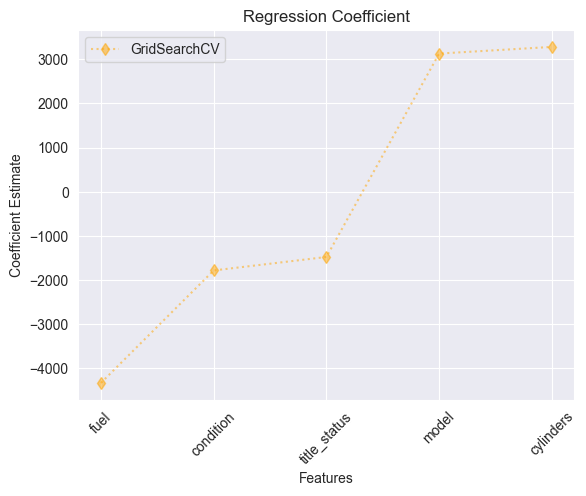

In [129]:
plt.plot(coeff_lrg_grid['features'],coeff_lrg_grid['Coefficient Estimate'],alpha=0.5,linestyle='dotted',marker='d',markersize=6,color='orange',label=f"GridSearchCV")
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Coefficient Estimate')
plt.title('Regression Coefficient')
plt.legend()
plt.show()

In [130]:
# Create an ensamble method to select best fit model
def reg_model_metrics(reg_models, X_train, X_test, y_train, y_test):
    """ Function takes in different dictionary of models and training and testing sets, 
    and ouputs the below metrics in a dataframe:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    6. Model training and test scores or accuracies
    7. Plots graph between actual vs predicted datasets
    """

    R2_result         = []
    adj_R2_result     = []
    MSE_result        = []
    RMSE_result       = []
    MAE_result        = []
    str_models        = []
    training_score    = []
    testing_score     = []

    for model_name, model in reg_models.items():

        # Get predicted values on x_test
        pred_model = model.fit(X_train,y_train)
        y_pred = pred_model.predict(X_test)
        str_models.append(str(model_name))

        #1 & 2 Coefficient of Determination (R² & Adjusted R²)
        r2 = r2_score(y_test,y_pred)
        adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        R2_result.append(round(r2, 2))
        adj_R2_result.append(round(adj_r2, 2))

        #3 & 4. MSE and RMSE
        mse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
        rmse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
        MSE_result.append(round(mse, 2))
        RMSE_result.append(round(rmse, 2))

        #5. MAE
        mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
        MAE_result.append(round(mae, 2))

        #6. Model training and test scores or accuracies
        train_score = round(pred_model.score(X_train, y_train)*100, 2)
        test_score = round(pred_model.score(X_test, y_test)*100, 2)

        training_score.append(train_score)
        testing_score.append(test_score)

        number_of_observations=50
        x_ax = range(len(y_test[:number_of_observations]))

        plt.figure(figsize=(16,8))
       
        plt.plot(x_ax, y_test[:number_of_observations], label="Actual", color='red', linewidth=2)
        plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted",  color='yellow', linewidth=2)
        
        plt.title("Used Car Prices: Predicted data - Actual using "+ model_name)
        plt.xlabel('Observation Number')
        plt.ylabel('Price')
        plt.xticks(np.arange(number_of_observations))
        plt.legend()
        plt.grid()
        plt.show();


    pd_metric = pd.DataFrame({'models':str_models, 'R2':R2_result,'Adj_R2':adj_R2_result,'MSE':MSE_result, 'RMSE':RMSE_result,
                              'MAE': MAE_result,'Training_Score':training_score, 'Test_Score':testing_score })
    pd_metric.set_index('models', inplace=True)
    return create_table(pd_metric, index_title='Models',index=True)

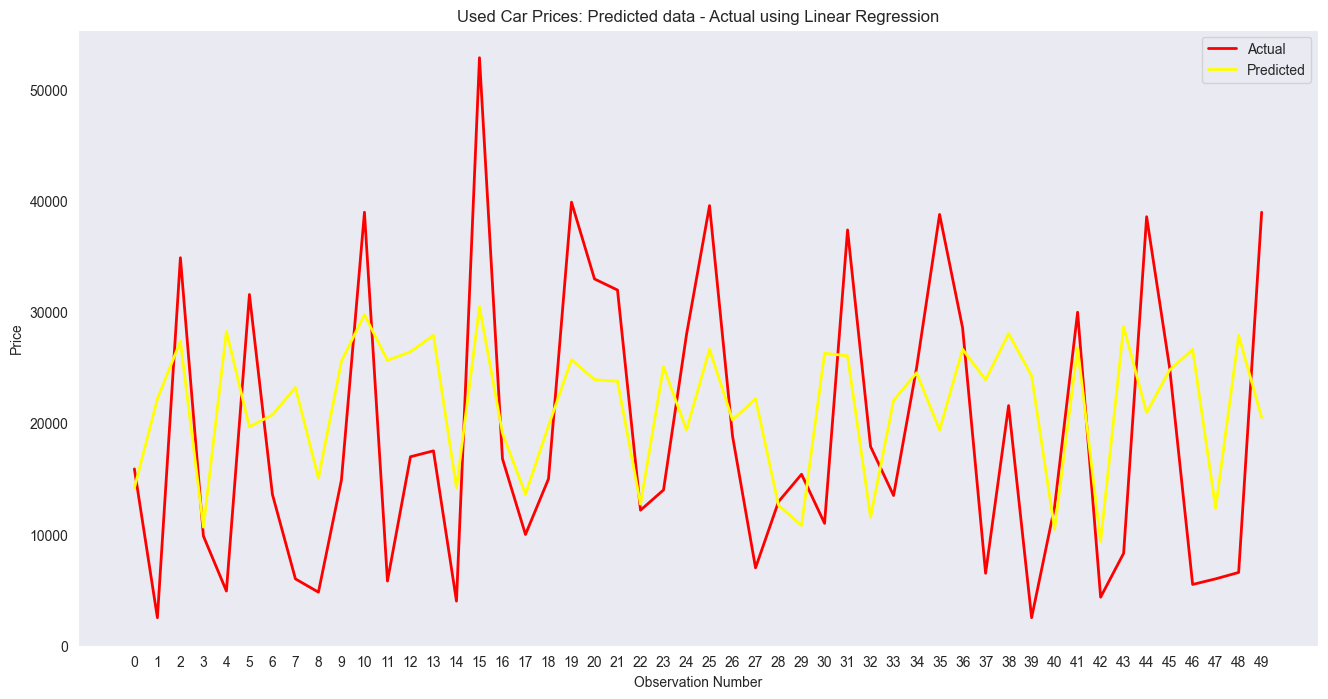

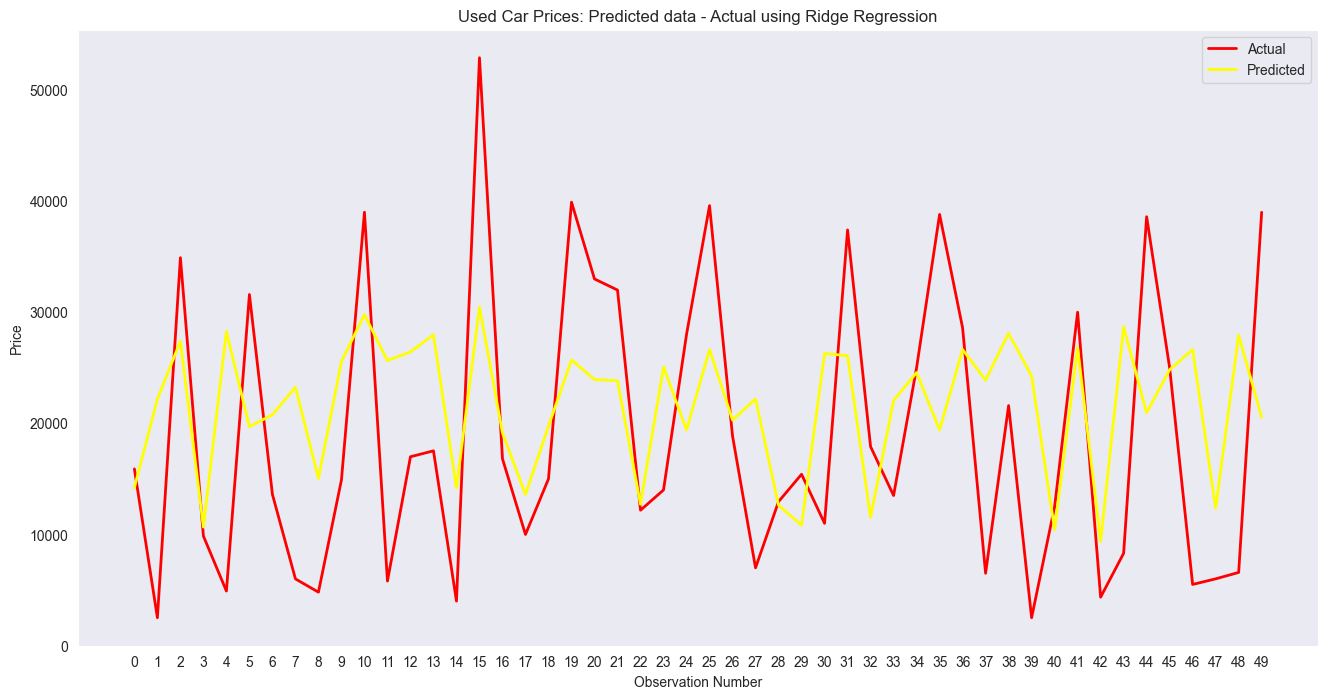

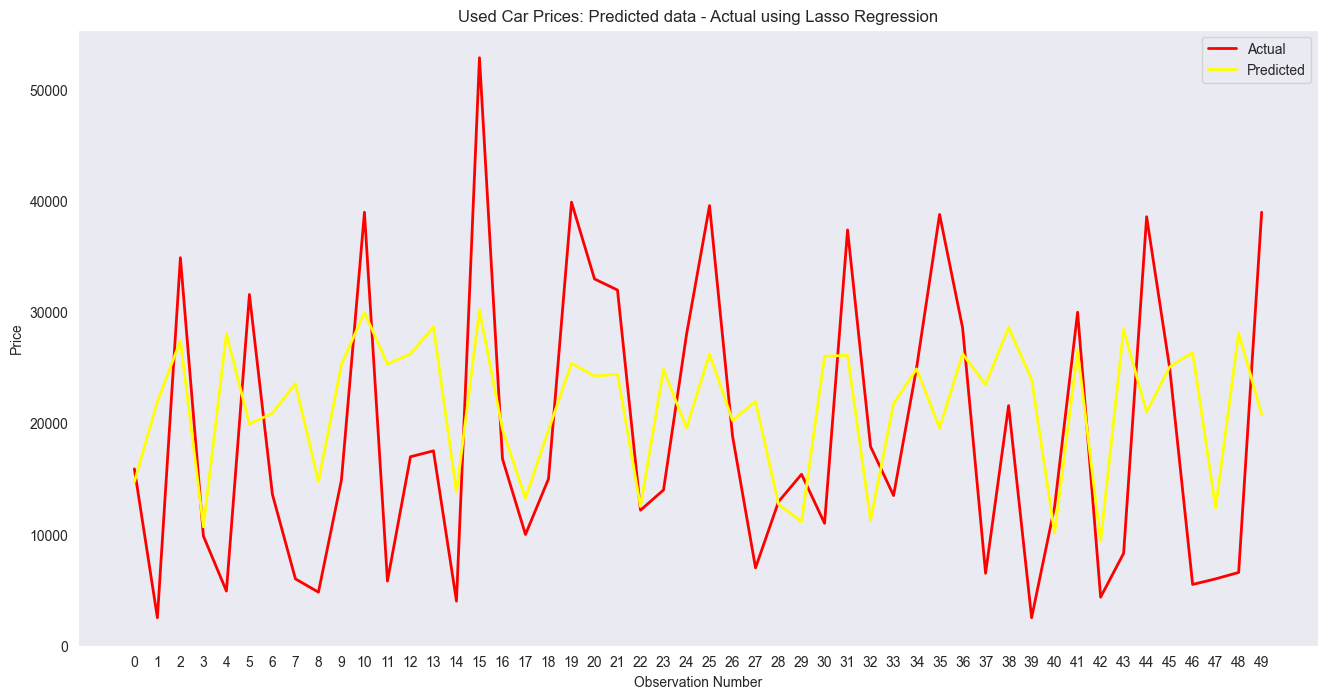

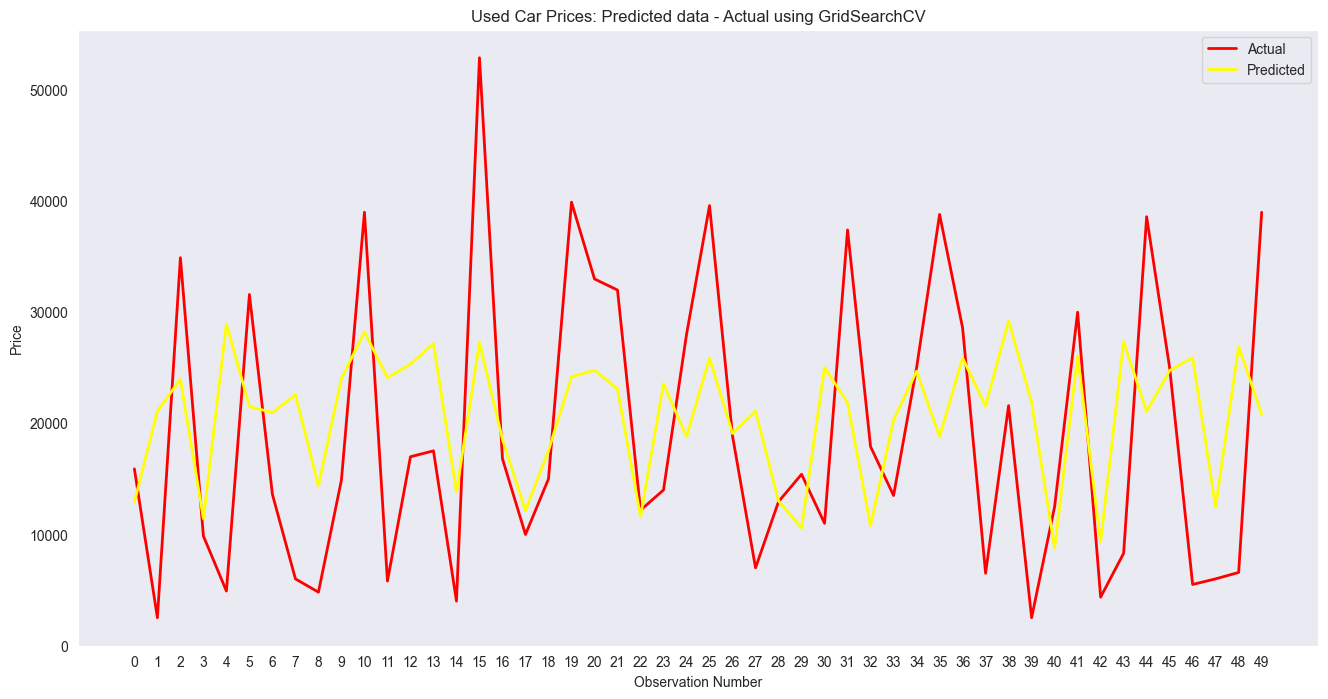

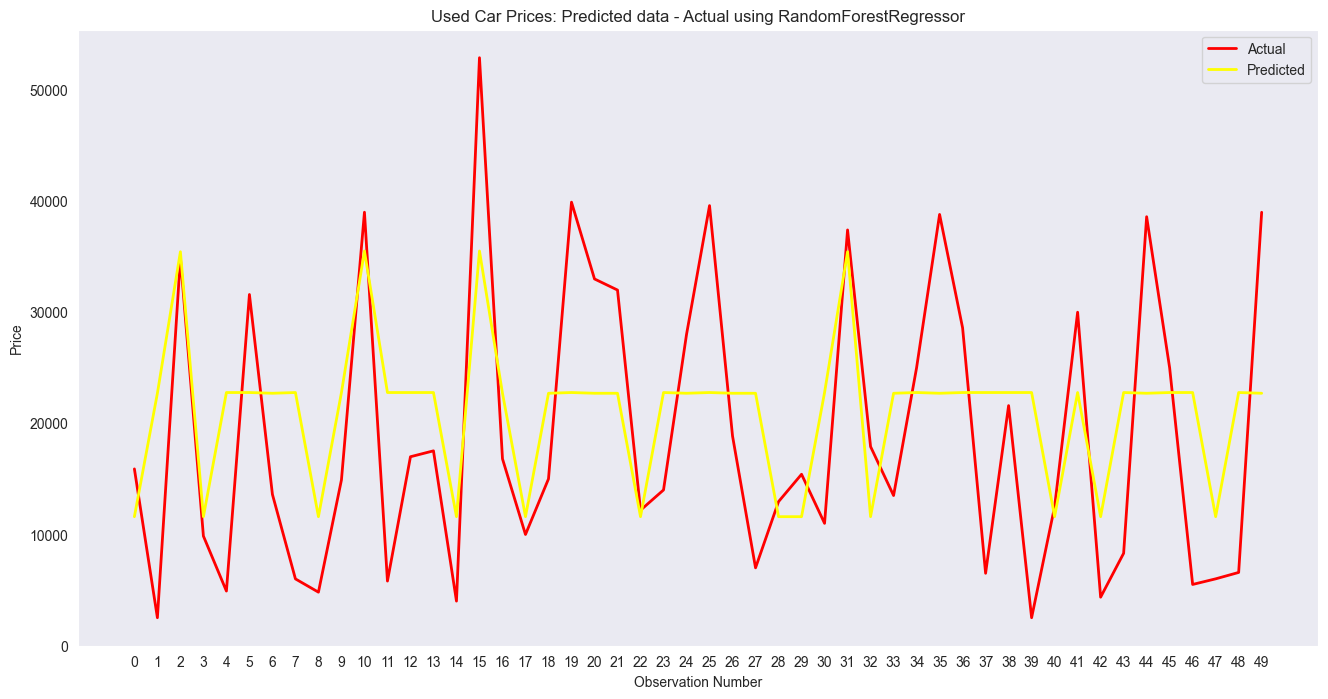

In [131]:
regression_models={'Linear Regression':linreg,
                   'Ridge Regression' : ridge1,
                   'Lasso Regression' : lasso,
                   'GridSearchCV': grid_search,
                   'RandomForestRegressor':rfr
                   }
reg_model_metrics(regression_models,X_train, X_val, y_train, y_val)

### The RandomForestRegressor Model has got the highest training and test scores, that model will be used for the prediction

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Assess the results, validate the models, and determine if the project’s objectives are met.

In [140]:
def predict_price(used_cars_sample_df):
    """ Function takes in a sample dataframe from the clean dataset, 
    and transforms the feature columns 
    and ouputs the the predicted price array:"""
    features = ['fuel','cylinders','title_status', 'condition', 'model']
    le = LabelEncoder().fit(list(used_cars_sample_df['model'].astype(str).values))
    used_cars_sample_df['model'] = le.transform(list(used_cars_sample_df['model'].astype(str).values))
    return regression_models['RandomForestRegressor'].predict(used_cars_sample_df[features])

In [141]:
sample_df = df_clean.sample(1)
predicted_price = predict_price(sample_df)

for i in range(1,20):
    sample_df = df_clean.sample(1)
    predicted_price = predict_price(sample_df)
    print('************************************')
    print('Actual Price: ', sample_df['price'].values[0], 'Predicted Price: ',predicted_price[0])

************************************
Actual Price:  10950 Predicted Price:  11594.273748824555
************************************
Actual Price:  6995 Predicted Price:  11594.273748824555
************************************
Actual Price:  7900 Predicted Price:  11594.273748824555
************************************
Actual Price:  16997 Predicted Price:  22701.32043893917
************************************
Actual Price:  43995 Predicted Price:  35504.70516275872
************************************
Actual Price:  5200 Predicted Price:  22701.32043893917
************************************
Actual Price:  27990 Predicted Price:  22767.46148024078
************************************
Actual Price:  7500 Predicted Price:  11594.273748824555
************************************
Actual Price:  17950 Predicted Price:  22767.46148024078
************************************
Actual Price:  30995 Predicted Price:  22701.32043893917
************************************
Actual Price:  3000 Pre

### Test Results:
1. The above script runs 20 random samples with our prediction model (RandomForestRegressor)
2. It looks the predicted values are not accurate
3. The models need additional tuning or selected features criteria do not explained the model

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

 Implement the model into the operational environment, if applicable. Plan monitoring and maintenance, Review project.
 

### Data observations

In [134]:
df_clean.query('age > 50').groupby(['age'])['price'].agg(['mean', 'count']).sort_values(by='count',ascending=False).head()

,mean,count
age,,
52,22824.200000,30
57,16582.173913,23
51,23542.611111,18
58,24118.125000,16
54,31629.133333,15


In [135]:
# Top 5 states that have maximum number of used car inventory are
df_clean.value_counts('state').head()

state
ca    6465
fl    4719
ny    3340
tx    2663
mi    2259
dtype: int64

In [136]:
# Top 5 manufacturer's cars in the used cars inventory are:
df_clean.value_counts('manufacturer').head()

manufacturer
ford         10272
chevrolet     8927
toyota        4644
nissan        3222
jeep          3084
dtype: int64

In [137]:
# Top priced used cars on an average are from these manufacturers:
(df_clean.groupby('manufacturer')['price'].mean().to_frame()).sort_values(by=['price'],  ascending=False).head(5)

,price
manufacturer,
ferrari,98157.928571
aston-martin,57280.000000
tesla,42543.000000
porsche,33015.668605
ram,29950.899384


In [138]:
# Most popular colors on average car price
(df_clean.groupby('paint_color')['price'].mean().to_frame()).sort_values(by=['price'],  ascending=False).head(5)

,price
paint_color,
red,22923.437551
white,22851.393115
yellow,22350.486683
black,22053.032727
orange,21077.656250


In [139]:
# Manufactures with most new cars in the second hand market
df_clean[['manufacturer']][df_clean['condition'] == 'new'].value_counts().to_frame().head(5)

,0
manufacturer,
ford,38
chevrolet,34
toyota,17
nissan,16
honda,15


### Data issues and Model issues
#### 1. There were many NaN
#### 2. Upto now only known models have been used
#### 3. introduction of hyperparameters tuning
#### 4. Current model use only 5 features for prediction
#### 5. The Normalized dataset has not been used yet, 
#### 6. the data distribution is a skewed right distribution  


### Recommendation
1. Increase permutation feature importance
2. Tuning technics to be used in the regression models
3. Some advanced models have been used but the best results are from the simple regression model
4. The prediction models are  at experimental stage, but can be productionised by converting it to python code api library with gui and interface api
5. For production environment can be deployed at cloud or local grid servers 